# Using Pòlya-Gamma Auxiliary Variables for Binary Classification

## Overview

In this notebook, we'll demonstrate how to use Pòlya-Gamma auxiliary variables to do efficient inference for Gaussian Process binary classification as in reference [1]. We will also use natural gradient descent, as described in more detail in the [Natural gradient descent](./Natural_Gradient_Descent.ipynb) tutorial.


[1] Florian Wenzel, Theo Galy-Fajou, Christan Donner, Marius Kloft, Manfred Opper. [Efficient Gaussian process classification using Pòlya-Gamma data augmentation](https://arxiv.org/abs/1802.06383). Proceedings of the AAAI Conference on Artificial Intelligence. 2019.

## Polya-Gamma Augmentation

When a Gaussian Process prior is paired with a Gaussian likelihood inference can be done exactly with a simple closed form expression.
Unfortunately this attractive feature does not carry over to non-conjugate likelihoods like the Bernoulli likelihood that arises in the context of binary classification with a logistic link function.
Sampling-based stochastic variational inference offers a general strategy for dealing with non-conjugate likelihoods; see the [corresponding tutorial](./Non_Gaussian_Likelihoods.ipynb).

Another possible strategy is to introduce additional latent variables that restore conjugacy. 
This is the strategy we follow here. In particular we are going to introduce a Polya-Gamma auxiliary variable for each data point in our training dataset. 
The [Polya-Gamma](https://arxiv.org/abs/1205.0310) distribution $\rm{PG}$ is a univariate distribution with support on the positive real line. 
In our context it is interesting because if $\omega_i$ is distributed according to $\rm{PG}(0,1)$ then the logistic likelihood $\sigma(\cdot)$ for data point $(x_i, y_i)$ can be represented as

\begin{align}
\sigma(y_i f_i) = \frac{1}{1 + \exp(-y_i f_i)} = \tfrac{1}{2} \mathbb{E}_{\omega_i \sim \rm{PG}(0,1)} \left[ \exp \left(\tfrac{1}{2} y_i f_i - \tfrac{\omega_i}{2} f_i^2 \right) \right]
\end{align}

where $y_i \in \{-1, 1\}$ is the binary label of data point $i$
and $f_i$ is the Gaussian Process prior evaluated at input $x_i$. 
The crucial point here is that $f_i$ appears quadratically in the exponential within the expectation. 
In other words, conditioned on $\omega_i$, we can integrate out $f_i$ exactly, just as if we were doing regression with a Gaussian likelihood. For more details please see the original reference. 

## Setup

In [1]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

For this example notebook, we'll create a simple artificial dataset.

In [2]:
import os
from math import floor

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

N = 100
X = torch.linspace(-1., 1., N)
probs = (torch.sin(X * math.pi).add(1.).div(2.))
y = torch.distributions.Bernoulli(probs=probs).sample()
X = X.unsqueeze(-1)

train_n = int(floor(0.8 * N))
indices = torch.randperm(N)
train_x = X[indices[:train_n]].contiguous()
train_y = y[indices[:train_n]].contiguous()

test_x = X[indices[train_n:]].contiguous()
test_y = y[indices[train_n:]].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

Let's plot our artificial dataset. 
Note that here the binary labels are 0/1-valued; we will need to be careful to translate between this representation and the -1/1 representation that is most natural in the context of Pòlya-Gamma augementation.

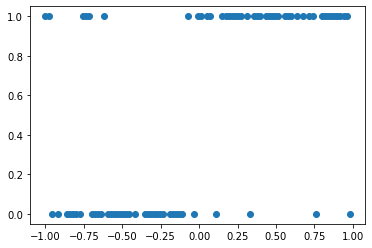

In [3]:
plt.plot(train_x.squeeze(-1), train_y, 'o')

The following steps create the dataloader objects. See the [SVGP regression notebook](./SVGP_Regression_CUDA.ipynb) for details.

In [4]:
from torch.utils.data import TensorDataset, DataLoader
train_i = torch.arange(0, len(train_x), device=train_x.device)
train_dataset = TensorDataset(train_i, train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100000000, shuffle=False)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## Variational Inference with PG Auxiliaries

We define a Bernoulli likelihood that leverages Pòlya-Gamma augmentation. 
It turns out that we can derive closed form updates for the Pòlya-Gamma auxiliary variables. To deal with the Gaussian Process we introduce inducing points and inducing locations. 
In particular we will need to learn a variational covariance matrix and a variational mean vector that control the inducing points. (See the discussion in the [SVGP tutorial](Approximate_GP_Objective_Functions.ipynb) for more details.) 
We will use natural gradient updates to deal with these two variational parameters; this will allow us to take large steps, thus yielding fast convergence. 

In [5]:
class PGLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    # this method effectively computes the expected log likelihood 
    # contribution to Eqn (10) in Reference [1].
    def expected_log_prob(self, target, input, indices, *args, **kwargs):
        mean, variance = input.mean, input.variance
        # Compute the expectation E[f_i^2]
        raw_second_moment = variance + mean.pow(2)

        # Translate targets to be -1, 1
        target = target.to(mean.dtype).mul(2.).sub(1.)

        # We detach the following variable since we do not want
        # to differentiate through the closed-form PG update.
        c = raw_second_moment.detach().sqrt()
        # Compute mean of PG auxiliary variable omega: 0.5 * Expectation[omega]
        # See Eqn (11) and Appendix A2 and A3 in Reference [1] for details.
        half_omega = 0.25 * torch.tanh(0.5 * c) / c

        # Expected log likelihood
        res = 0.5 * target * mean - half_omega * raw_second_moment
        # Sum over data points in mini-batch
        res = res.sum(dim=-1)

        return res
    
    # define the likelihood
    def forward(self, function_samples):
        return torch.distributions.Bernoulli(logits=function_samples)
    
    # define the marginal likelihood using Gauss Hermite quadrature
    def marginal(self, function_dist):
        prob_lambda = lambda function_samples: self.forward(function_samples).probs
        probs = self.quadrature(prob_lambda, function_dist)
        return torch.distributions.Bernoulli(probs=probs)
    

# define the actual GP model (kernels, inducing points, etc.)  
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# we initialize our model with M = 30 inducing points
M = 30
inducing_points = torch.linspace(-2., 2., M, dtype=train_x.dtype, device=train_x.device).unsqueeze(-1)
model = GPModel(inducing_points=inducing_points)
model.covar_module.base_kernel.initialize(lengthscale=0.2)
likelihood = PGLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

### Setup optimizers

We will use a `NGD` (Natural Gradient Descent) optimizer to deal with the inducing point covariance matrix and corresponding mean vector, while we will use the `Adam` optimizer for all other parameters (the kernel hyperparmaeters as well as the inducing point locations). 
Note that we use a pretty large learning rate for the `NGD` optimizer.

In [6]:
variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

### Define training loop

In [7]:
model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 1 if smoke_test else 100
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    
    for i_batch, x_batch, y_batch in minibatch_iter:
        ### Perform NGD step to optimize variational parameters
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        
        output = model(x_batch)
        loss = -mll(output, y_batch, indices=i_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

### Visualization and Evaluation

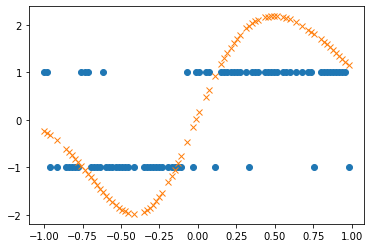

In [8]:
# push training data points through model
train_mean_f = model(train_x).loc.data.cpu()
# plot training data with y being -1/1 valued
plt.plot(train_x.squeeze(-1), train_y.mul(2.).sub(1.), 'o')
# plot mean gaussian process posterior mean evaluated at training data
plt.plot(train_x.squeeze(-1).cpu(), train_mean_f.cpu(), 'x')

As expected the Gaussian Process posterior mean (plotted in orange) gives confident predictions in the regions
where the correct label is unambiguous (e.g. for x ~ 0.5) and gives unconfident predictions in regions where
the correct label is ambiguous (e.g. x ~ 0.0).

We compute the negative log likelihood (NLL) and classification accuracy on the held-out test data.

In [9]:
model.eval()
likelihood.eval()
with torch.no_grad():
    nlls = -likelihood.log_marginal(test_y, model(test_x))
    acc = (likelihood(model(test_x)).probs.gt(0.5) == test_y.bool()).float().mean()
print('Test NLL: {:.4f}'.format(nlls.mean()))
print('Test Acc: {:.4f}'.format(acc.mean()))

Test NLL: 0.3014
Test Acc: 0.9500
